In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import subprocess
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

In [2]:
def find(reg, linhas):
    # cria a lista que vai ser retornada como resultado da funcao com a palavra e seu valor
    busca_resultado = []
    # for para varrer todas as linhas, o valor de i indica qual á linha em linhas[i]
    for i in range(len(linhas)):
        # for para varrer cada linha a procura da palavra buscada
        for item in linhas[i]:
            # verifica se o registro esta na linha
            if item == reg:
                # este for e para varrer novamente a linha se achar o registro para gravar todos os valores da linha em uma lista
                for item in linhas[i]:
                    if item != reg:
                        busca_resultado.append(item)
    return busca_resultado


def find_n_line(reg, linhas):
    # cria a lista que vai ser retornada como resultado da funcao com a palavra e seu valor
    busca_resultado = []
    # for para varrer todas as linhas, o valor de i indica qual á linha em linhas[i]
    j = 0
    for i in range(0, len(linhas)):
        # for para varrer cada linha a procura da palavra buscada
        for item in linhas[i]:
            # verifica se o registro esta na linha
            if item == reg:
                # este for e para varrer novamente a linha se achar o registro para gravar todos os valores da linha em uma lista
                busca_resultado.append(j)
        j += 1
    return busca_resultado


# function that transform file in to list. input name: path and the name of the file.
def open_file(name):
    file = open(name, 'r', encoding='utf-8',
                errors='ignore')  # open the file.
    # creat a list that will be full filed with the file with a line as a list element.
    file_list = []
    for line in file:  # open a loop that cover the file.
        line = line.strip('\n')  # drop out all '\n' contained in every line.
        # change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
        line = line.split()
        file_list.append(line)  # add the line in the list file_list.
    file.close()  # close de file.
    return file_list


def change_coluns_pdos(arquivo):
    # abre o arquivo scf.out
    arq = open(arquivo, 'r')
    # cria a lista que contenhaa cada linha do arquvio cif como um elemento da lista
    new_arq = []
    ct = 0
    for linha in arq:
        # retira o \n de quebra de linnha da linha
        line = linha.strip('\n')
        # retira os espaços entre os elementos da linha, assim criando uma lista
        line = line.split()
        if ct == 0 and line[0] == '#':
            line.remove('#')
            new_line = []
            for item in line:
                if item != '(eV)':
                    new_line.append(item)
        else:
            new_line = line
        new_arq.append(new_line)
        ct += 1
    # fecha o arquivo
    arq.close()

    arq = open(arquivo,'w')
    for item in new_arq:
        line = ''
        for word in item:
            line+= word + '   '
        line += '\n'
        arq.writelines(line)
    arq.close()
    return 0

def version_quantum(file):
    for line in file:
        for item in line:
            if item == 'Program':
                version = line[2][2:]
    return version

def E_fermi(file,type,version):
    i =0
    for line in file:
        for item in line:
            if version == '7.1':
                if type == 'bands.out' or type == 'nscf.out':
                    if item == "Fermi":
                        count = i
                    elif item == "occupied," or item == "occupied":
                        count = i
                elif type == 'scf.out':
                    if item == "Fermi":
                        count = i
                    elif item == "occupied," or item == "occupied":
                        count = i    
            elif version == '6.7MaX':
                if type == 'scf.out':
                    if item == "Fermi":
                        count = i
                    elif item == "occupied," or  item ==  "occupied":
                        count = i    
                
        i+=1
    for item in file[count]:
        try:
            E_f = round(float(item), 4)
            break
        except ValueError:
                pass
    return E_f


def atoms(scf_in_file):
    i = 0;atom = []
    for line in scf_in_file:
        for item in line:
            if item == 'ATOMIC_SPECIES' or item == 'atomic_species':
                count1 = i+1
            elif item == 'ATOMIC_POSITIONS' or item == 'atomic_positions':
                count2 = i
        i+=1
    for j in range(count1,count2):
        atom.append(scf_in_file[j][0])
    return atom


def pdos_files_get(path,prefix,atoms):
    pdos_files = []
    for dir,subdir,files in os.walk(path):
        for file in files:
            if file[:len(prefix)] == prefix and file != prefix+'.pdos.dat.pdos_tot' and file != prefix + '.pdos-proj.dat.projwfc_up' and file != prefix+'.pdos_tot':
                pdos_files.append(os.path.join(path,file))

    pdos_atom_dict = {};pdos_orb_dict = {}
    for a in range(len(atoms)):
        list = [];orb_list = []
        for name in pdos_files:
            for i in range(1,len(name)):
                if len(atoms[a]) == 1:
                    if name[i] == '(' and name[i+1] == atoms[a]:
                        list.append(name)
                    elif name[i] == '(' and name[i+1] == 's':
                        if (name[i+1] in orb_list) == False:
                            orb_list.append(name[i+1])
                    elif name[i] == '(' and name[i+1] == 'p':
                        if (name[i+1] in orb_list) == False:
                            orb_list.append(name[i+1])
                    elif name[i] == '(' and name[i+1] == 'd':
                       if (name[i+1] in orb_list) == False:
                            orb_list.append(name[i+1])
                    elif name[i] == '(' and name[i+1] == 'f':
                        if (name[i+1] in orb_list) == False:
                            orb_list.append(name[i+1])                       
                else:
                    if name[i-1] == '(' and name[i] == atoms[a][0] and name[i+1] == atoms[a][1]:
                        list.append(name)
                    elif name[i] == '(' and name[i+1] == 's':
                        if (name[i+1] in orb_list) == False:
                            orb_list.append(name[i+1])
                    elif name[i] == '(' and name[i+1] == 'p':
                        if (name[i+1] in orb_list) == False:
                            orb_list.append(name[i+1])
                    elif name[i] == '(' and name[i+1] == 'd':
                       if (name[i+1] in orb_list) == False:
                            orb_list.append(name[i+1])
                    elif name[i] == '(' and name[i+1] == 'f':
                        if (name[i+1] in orb_list) == False:
                            orb_list.append(name[i+1])     

        pdos_atom_dict[atoms[a]] = list
        pdos_orb_dict[atoms[a]] = orb_list

    pdos_atom_orb_dict = {}
    for atom in atoms:
        pdos_atom_orb_dict[atom] = {}
        for orb in pdos_orb_dict[atom]:
            pdos_atom_orb_dict[atom][orb] = []
            list = []
            for file in pdos_atom_dict[atom]:
                for i in range(len(file)):
                    if file[i] == '(' and file[i+1] == orb:
                        list.append(file)
            pdos_atom_orb_dict[atom][orb] = list

    return [pdos_atom_dict,pdos_atom_orb_dict]


def bandas_df(arquivo):
    bandas = pd.read_csv(arquivo, delim_whitespace=True,
                         names=['k', 'E'], dtype=float)
    # subtrai todos os valores pelo nivel de fermi
    return bandas


def orbitais(bandas, ef, Ef):
    # nesse bloco sera feito a separaçao do data frame em varias colunas, onde cada coluna é referente a uma banda
    # neste passo vamos obter do dataFrame Bandas original apenas os valores de momento que nao são repetidos
    # cria a lista para armazenaros valroes
    if ef == True:
        bandas['E'] -= Ef
    momentos = []
    # for para varrer todos os indices do dataframe
    for i in bandas.index:
        # pega o valor do momento para o indice i, no caso a linha i do data frame
        mom = bandas.loc[i][0]
        # cria uma condicao para adicionar na lista apenas itens nao repetidos, ou seja se mom nao estiver na  lista momentos, entao ele sera adicionado a mesma, caso contrario nada e feito
        condicao = mom in momentos
        if condicao == False:
            momentos.append(mom)
    # variavel para fazer a contagem total do numero de bandas
    n_bnd = 0
    # para fazer a contagem vamso pegar todos os valores de k na coluna "k" do dataframe Bandas, sempre que k=0, quer dize que começamos uma nova banda, portanto a
    # condicao de troca de bandas sera quando k=0, sempre que isso acontecer, adicionamos +1 no valor de n_bnd(numero de bandas)
    cond = bandas["k"] == 0
    # começa o for varrendo todos os valores de k contidos na coluna bandas["k"]
    for item in cond:
        if item == True:
            n_bnd += 1
        else:
            pass
    # cria o novo dataFrame com a coluna contendo apenas os valores de k que nao sao repetidos
    df = pd.DataFrame(momentos, columns=["K"], dtype=float)
    # começa com o menor valor posivel para a energia da banda de valencia
    E_valencia = min(bandas['E'])
    # começa com o maior valor posivel para a energia da banda de conduçao
    E_conducao = max(bandas['E'])
    gap = True
    # loop para varrer todas as bandas do data frame
    for j in range(n_bnd):
        # cria a lista que vai armazear os valores de energia para a banda j
        energia = []
        # loop para varrer todos os valores de energia contidos no dataframe original que coresponem a banda j
        for i in range(len(momentos)):
            e = bandas.loc[i+j*len(momentos)][1]
            energia.append(e)
        # cria uma nova coluna no novo dataframe adicionando todos os valores de energia da banda j
        df["orb "+str(j)] = energia
        #verifica se é metal
        e_min = min(energia); e_max = max(energia)
        if ef == False:
            if e_min <Ef and e_max>Ef:
                gap = False
        else:
            if e_min <0 and e_max>0:
                gap = False

        # atualiza o valor da energia de valencia
        if ef == False:
            if max(energia) >= E_valencia and max(energia) <= Ef:
                E_valencia = max(energia)
                for k in range(len(energia)):
                    if energia[k] == E_valencia:
                        E_valencia_point = [momentos[k],energia[k]]
            # atualiza o valor da energia de conduçao
            elif min(energia) <= E_conducao and min(energia) >= Ef:
                E_conducao = min(energia)
                for k in range(len(energia)):
                    if energia[k] == E_conducao:
                        E_conducao_point = [momentos[k],energia[k]]
        else:
            if max(energia) >= E_valencia and max(energia) <= 0:
                E_valencia = max(energia)
                for k in range(len(energia)):
                    if energia[k] == E_valencia:
                        E_valencia_point = [momentos[k],energia[k]]                
            # atualiza o valor da energia de conduçao
            elif min(energia) <= E_conducao and min(energia) >= 0:
                E_conducao = min(energia)
                for k in range(len(energia)):
                    if energia[k] == E_conducao:
                        E_conducao_point = [momentos[k],energia[k]]
    if gap == True:
        return [df, round(E_valencia,3), round(E_conducao,3),E_valencia_point,E_conducao_point]
    else:
        if ef == False:
            return [df, Ef, Ef,0,0]
        else:
            return [df,0, 0,0,0]

def k_point(bandin_file):
    k_points_band = []
    k_points_letter = []
    i = 0
    for line in bandin_file:
        if len(line) >= 1:
            if line[0] == 'K_POINTS':
                n_line = i
        i += 1
    n_kpoints = int(bandin_file[n_line+1][0])
    for i in range(n_line+2, n_line+2+n_kpoints):
        k_points_band.append(np.array(bandin_file[i][:3], dtype=float))
        if bandin_file[i][4][1:] == 'G':
            k_points_letter.append('$\Gamma$')
        else:
            k_points_letter.append(bandin_file[i][4][1:])
    return [k_points_letter, k_points_band]


def k_points_path(file, n_k):
    i = 0
    k_points_bandsx = []
    k_path = []
    for line in file:
        for item in line:
            if item == 'wavefunctions':
                n_line = i+1
        i += 1
    for j in range(n_line, n_line + n_k):
        k_points_bandsx.append(np.array(file[j][2:5], dtype=float))
        k_path.append(float(file[j][7]))
    return [k_path, k_points_bandsx]


In [3]:
class File:  # this class is relative to treatement of the raw data in to a better analize format
    def __init__(self):  # load the input file
        self.file_dir = './'
        self.scfin_file_name = 'scf.in'
        self.scfout_file_name = 'scf.out'
        # must have ! in front of k letter, like 0.3333333 0.3333333 0.00000000 !K , for gamma point use G
        self.bandin_file_name = 'bands.in'
        self.bandout_file_name = 'bands.out'
        self.bandxout_file_name = 'bands.x.out'
        self.band_file_name = 'bands.dat.gnu'
        self.dos_file_name = 'dos'
        self.pdos_file_name = 'pdos.dat.pdos_tot'
        self.pdos_prefix = ''
        self.fermi_energy = 0

    def reset_atributes(self):
        del(self.file_dir)
        del(self.scfin_file_name)
        del(self.scfout_file_name)
        del(self.bandin_file_name)
        del(self.bandout_file_name)
        del(self.bandxout_file_name)
        del(self.band_file_name)
        del(self.dos_file_name)
        del(self.pdos_file_name)
        del(self.pdos_prefix)
        del(self.fermi_energy)

        self.file_dir = './'
        self.scfin_file_name = 'scf.in'
        self.scfout_file_name = 'scf.out'
        self.nscfin_file_name = 'nscf.in'
        self.nscfout_file_name = 'nscf.out'
        # must have ! in front of k letter, like 0.3333333 0.3333333 0.00000000 !K , for gamma point use G
        self.bandin_file_name = 'bands.in'
        self.bandout_file_name = 'bands.out'
        self.bandxout_file_name = 'bands.x.out'
        self.band_file_name = 'bands.dat.gnu'
        self.dos_file_name = 'dos'
        self.pdos_file_name = 'pdos.dat.pdos_tot'
        self.pdos_prefix = ''
        self.fermi_energy = 0

    def Set_files_atributes(self, dict):
        keys = dict.keys()
        for key in keys:
            if key == 'files_folder':
                self.file_dir = dict[key]
            elif key == 'scf_in_name':
                self.scfin_file_name = dict[key]
            elif key == 'scf_out_name':
                self.scfout_file_name = dict[key]
            elif key == 'nscf_in_name':
                self.nscfin_file_name = dict[key]
            elif key == 'nscf_out_name':
                self.nscfout_file_name = dict[key]
            elif key == 'bands_in_name':
                self.bandin_file_name = dict[key]
            elif key == 'bands_out_name':
                self.bandout_file_name = dict[key]
            elif key == 'bandsx_name':
                self.bandxout_file_name = dict[key]
            elif key == 'bands_dat_name':
                self.band_file_name = dict[key]
            elif key == 'dos_dat_name':
                self.dos_file_name = dict[key]
            elif key == 'pdos_dat_name':
                self.pdos_file_name = dict[key]
            elif key == 'pdos_prefix':
                self.pdos_prefix = dict[key]

    def Load(self):
        self.scfin_file_path = os.path.join(
            self.file_dir, self.scfin_file_name)
        self.scfin_file = open_file(self.scfin_file_path)

        self.scfout_file_path = os.path.join(
            self.file_dir, self.scfout_file_name)
        self.scfout_file = open_file(self.scfout_file_path)
        self.version_QE = version_quantum(self.scfout_file)
        self.fermi_energy = E_fermi(self.scfout_file,'scf.out',self.version_QE)

    def Bands_files(self, fermi_energy_corr=True):
        self.bandout_file_path = os.path.join(self.file_dir, self.bandout_file_name)
        self.bandout_file = open_file(self.bandout_file_path)
        self.version_QE = version_quantum(self.bandout_file)
        if self.version_QE == '7.1':
            self.fermi_energy = E_fermi(self.bandout_file,'bands.out',self.version_QE)


        self.band_file_path = os.path.join(self.file_dir, self.band_file_name)
        bands = bandas_df(self.band_file_path)
        self.bands, self.E_valence, self.E_conduction, self.E_valence_point,self.E_conduction_point = orbitais(
            bands, fermi_energy_corr, self.fermi_energy)
        self.gap = self.E_conduction - self.E_valence

        self.bandin_file_path = os.path.join(
            self.file_dir, self.bandin_file_name)
        self.bandin_file = open_file(self.bandin_file_path)
        self.k_points_letter, self.k_points_bands = k_point(self.bandin_file)

        self.bandxout_file_path = os.path.join(
            self.file_dir, self.bandxout_file_name)
        self.bandxout_file = open_file(self.bandxout_file_path)
        self.k_path, self.k_points_bandsx = k_points_path(
            self.bandxout_file, len(self.k_points_letter))

    def Dos_files(self, calculation, fermi_energy_corr=True):  # dos via projwfc.x, nao usar dos.x
        self.nscfout_file_path = os.path.join(self.file_dir, self.nscfout_file_name)
        self.nscfout_file = open_file(self.nscfout_file_path)
        self.version_QE = version_quantum(self.nscfout_file)
        if self.version_QE == '7.1':
            self.fermi_energy = E_fermi(self.nscfout_file,'nscf.out',self.version_QE)

        if calculation == 'projwfc.x':
            self.dos_file_path = os.path.join(
                self.file_dir, self.pdos_file_name)
            change_coluns_pdos(self.dos_file_path)
            self.dos_file = open_file(self.dos_file_path)
            self.dos = pd.DataFrame(self.dos_file)
            self.dos = self.dos.drop(0)
            self.dos = self.dos.rename(columns={0: 'E', 1: 'dos', 2: 'pdos'})
            self.dos = self.dos.astype(float)
            if fermi_energy_corr == True:
                self.dos[self.dos.columns[0]] -= self.fermi_energy
            elif fermi_energy_corr == False:
                pass
            else:
                print(
                    'Wrong value for fermi_energy_corr parameter, only True or False values are accepted. Default = True')

        elif calculation == 'dos.x':
            self.dos_file_path = os.path.join(
                self.file_dir, self.dos_file_name)
            change_coluns_pdos(self.dos_file_path)
            self.dos_file = open_file(self.dos_file_path)
            self.dos_file.remove(self.dos_file[0])
            self.dos = pd.DataFrame(self.dos_file)
            self.dos = self.dos.rename(
                columns={0: 'E', 1: 'dos', 2: 'int_dos'})
            self.dos = self.dos.astype(float)
            if fermi_energy_corr == True:
                self.dos[self.dos.columns[0]] -= self.fermi_energy
            elif fermi_energy_corr == False:
                pass
            else:
                print(
                    'Wrong value for fermi_energy_corr parameter, only True or False values are accepted. Default = True')
        else:
            print(
                "Wrong value for calculation parameter, only 'dos.x' or 'projwfc.x' are accepted.")

    def Pdos_files(self, fermi_energy_corr=True): 

        self.pdos_per_atoms_files, self.pdos_per_orb_files = pdos_files_get(self.file_dir,self.pdos_prefix,atoms(self.scfin_file))  

        self.nscfout_file_path = os.path.join(self.file_dir, self.nscfout_file_name)
        self.nscfout_file = open_file(self.nscfout_file_path)
        self.version_QE = version_quantum(self.nscfout_file)
        if self.version_QE == '7.1':
            self.fermi_energy = E_fermi(self.nscfout_file,'nscf.out',self.version_QE)
        
        #per atoms 
        pdos_files = {}
        for atom in self.pdos_per_atoms_files.keys():
            i = 0
            for file in self.pdos_per_atoms_files[atom]:
                change_coluns_pdos(file)
                if i ==0:
                    df = pd.read_csv(file, delim_whitespace= True,dtype=float)
                    df.drop(df.columns[2:], axis='columns', inplace=True)
                    maxi = df[df.columns[1]].max()
                else:
                    df2 = pd.read_csv(file, delim_whitespace= True,dtype=float )
                    df[df.columns[1]]+=df2[df2.columns[1]]
                    del(df2)
                i+=1
            if fermi_energy_corr == True:
                df[df.columns[0]] -= self.fermi_energy
                pdos_files[atom] = df
            elif fermi_energy_corr == False:
                pdos_files[atom] = df
            else:
                print(
                    'Wrong value for fermi_energy_corr parameter, only True or False values are accepted. Default = True')
        
        self.pdos_per_atoms = pdos_files
        
        #per orb
        orb_files = {}
        for atom in self.pdos_per_orb_files.keys():
            orb_files[atom] = {}
            for orb in self.pdos_per_orb_files[atom]:
                i =0
                for file in self.pdos_per_orb_files[atom][orb]:
                    change_coluns_pdos(file)
                    if i ==0:
                        df = pd.read_csv(file, delim_whitespace= True,dtype=float)
                        df.drop(df.columns[2:], axis='columns', inplace=True)
                    else:
                        df2 = pd.read_csv(file, delim_whitespace= True,dtype=float )
                        df[df.columns[1]]+=df2[df2.columns[1]]
                        del(df2)
                    i+=1
                if fermi_energy_corr == True:
                    df[df.columns[0]] -= self.fermi_energy
                    orb_files[atom][orb] = df

                elif fermi_energy_corr == False:
                    orb_files[atom][orb] = df
                else:
                    print(
                        'Wrong value for fermi_energy_corr parameter, only True or False values are accepted. Default = True')   
        self.pdos_per_orb = orb_files             
        
class Plot:
    def bands(self, data, k_points_letter, k_path, subplotsize=(10, 8), subplot=False, ax=None, vline=True, vline_linewidth=1, E_min=-5, E_max=5, dE=1, font_axis=20, font_label=20, ylabel='E -EF (eV)', xlabel='', title='Band Structure',
              linewidth=3, legend=False, loc="upper right", color='black', color_vline='gray', vline_linestyle='dashed', label_band='eletronic strucuture', fermi_level_line=False, fermi_level=0, fermi_level_color='red', 
              fermi_level_linewidth=1, fermi_level_linestyle='dashed', occupied_and_unoccupied_states_dot = False, occupied_and_unoccupied_states_points = ((0,0),(0,0)), scatter_type = 'o',occupied_and_unoccupied_states_color_dot = 'blue',
              occupied_and_unoccupied_states_line=False, occupied_and_unoccupied_states=(-1, 1), occupied_and_unoccupied_states_color=('blue', 'blue'), occupied_and_unoccupied_states_linewidth=1,occupied_and_unoccupied_states_size_dot=80) :
        # flag subplot
        if subplot == False:
            del (ax)
            fig, ax = plt.subplots(figsize=subplotsize)
        # -----------------------------------------------------------------------------------------------------
        # plot data
        columns = data.columns
        k = data[columns[0]]
        for i in range(1, len(columns)):
            energy = data[columns[i]]
            if legend == True:
                if i == 1:
                    ax.plot(k, energy, color=color,
                            linewidth=linewidth, label=label_band)
                else:
                    ax.plot(k, energy, color=color, linewidth=linewidth)
            else:
                ax.plot(k, energy, color=color, linewidth=linewidth)
        # -----------------------------------------------------------------------------------------------------
        # flag vline
        if vline == True:
            for i in range(1, len(k_path)-1):
                ax.vlines(k_path[i], E_min, E_max, linestyles=vline_linestyle,
                          colors=color_vline, linewidth=vline_linewidth)
        # -----------------------------------------------------------------------------------------------------
        # flag fermy_level_line
        if fermi_level_line == True:
            ax.hlines(fermi_level, k_path[0], k_path[len(
                k_path)-1], linestyles=fermi_level_linestyle, color=fermi_level_color, linewidth=fermi_level_linewidth)
        # -----------------------------------------------------------------------------------------------------
        # flag occupied_and_unoccupied_states_line
        if occupied_and_unoccupied_states_line == True and occupied_and_unoccupied_states_dot == False:
            for i in range(len(occupied_and_unoccupied_states)):
                item = occupied_and_unoccupied_states[i]
                ax.hlines(item, k_path[0], k_path[len(k_path)-1], linestyles=fermi_level_linestyle,
                          linewidth=occupied_and_unoccupied_states_linewidth, color=occupied_and_unoccupied_states_color[i])
        elif occupied_and_unoccupied_states_line == False and occupied_and_unoccupied_states_dot == True:
            x = []; y = []
            for item in occupied_and_unoccupied_states_points:
                x.append(item[0]); y.append(item[1])
            ax.scatter(x,y, marker = scatter_type,s= occupied_and_unoccupied_states_size_dot, color = occupied_and_unoccupied_states_color_dot)
        # -----------------------------------------------------------------------------------------------------

        # flag legend
        if legend == True:
            ax.legend(loc=loc, fontsize=font_label)
        # -----------------------------------------------------------------------------------------------------
        # globar parameters
        ax.set_xlim(k_path[0], k_path[len(k_path)-1])
        ax.set_xticks(k_path, k_points_letter, fontsize=font_axis)
        ax.set_xlabel(xlabel)

        ax.set_ylim(E_min, E_max)
        ax.set_yticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)
        ax.set_ylabel(ylabel)
        ax.xaxis.label.set_size(font_label)
        ax.yaxis.label.set_size(font_label)

        ax.set_title(title, fontsize=font_label)

        return ax

    def dos(self, data, subplotsize=(10, 8), subplot=False, ax=None, color='black', linewidth=3, label='dos', legend = False, loc = 'upper right', font_label = 20, fill = False, fill_color ='blue', alpha = 0.5,
            E_min = -5, E_max = 5 ,dE = 1, dos_min = 0, dos_max = 10, delta_dos = 2, font_axis = 20, xlabel = 'E - E_F (eV)', ylabel = 'DoS (states/eV)', title = 'Density of States',
            fermi_level_line = False, fermi_level= 0, fermi_level_color='red', fermi_level_linewidth=1, fermi_level_linestyle='dashed'
            ):
        # flag subplot
        if subplot == False:
            del (ax)
            fig, ax = plt.subplots(figsize=subplotsize)
        # plot data
        energy = data[data.columns[0]]
        dos = data[data.columns[1]]
        ax.plot(energy, dos, color = color, linewidth = linewidth, label = label)

        #flag fill_between
        if fill == True:
            ax.fill_between(energy,dos, color = fill_color   ,alpha = alpha)

        # flag fermy_level_line
        if fermi_level_line == True:
            ax.vlines(fermi_level, dos_min, dos_max , linestyles=fermi_level_linestyle, color=fermi_level_color, linewidth=fermi_level_linewidth)

        # flag legend
        if legend == True:
            ax.legend(loc=loc, fontsize=font_label)

        # globar parameters
        ax.set_xlim(E_min, E_max)
        ax.set_xticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)
        ax.set_xlabel(xlabel)

        ax.set_ylim(dos_min, dos_max)
        ax.set_yticks(np.arange(dos_min, dos_max+delta_dos, delta_dos),
                      np.arange(dos_min, dos_max+delta_dos, delta_dos), fontsize=font_axis)
        ax.set_ylabel(ylabel)
        ax.xaxis.label.set_size(font_label)
        ax.yaxis.label.set_size(font_label)

        ax.set_title(title, fontsize=font_label)
        return ax

    def pdos_atoms(self, dict, subplotsize=(10, 8), subplot=False, ax=None, all_atom = True, atom = ['A','B'], linestyle = 'solid',
     linewidth=3, legend = True, loc = 'upper right', font_label = 20, fill = False, fill_color ='blue', alpha = 0.5,
            E_min = -5, E_max = 5 ,dE = 1, dos_min = 0, dos_max = 10, delta_dos = 1, font_axis = 20, xlabel = 'E - E_F (eV)', ylabel = 'DoS (states/eV)', title = 'Density of States per Atom',
            fermi_level_line = False, fermi_level= 0, fermi_level_color='red', fermi_level_linewidth=1, fermi_level_linestyle='dashed'):
        #flag subplot
        if subplot == False:
            del (ax)
            fig, ax = plt.subplots(figsize=subplotsize)
    
        list_data = []
        for key in dict.keys():
            ### flag all_atom
            if all_atom == True:
                data = dict[key]
                x = data[data.columns[0]]
                y = data[data.columns[1]]
                ax.plot(x, y, linewidth = linewidth, label = key , linestyle = linestyle)
                list_data.append(y)
            elif all_atom == False:
                if (key in atom) == True:
                    data = dict[key] 
                    x = data[data.columns[0]]
                    y = data[data.columns[1]]
                    list_data.append(y)
                    ax.plot(x, y, linewidth = linewidth, label = key ,linestyle = linestyle)
            else:
                print('Wrong value for all_atom parameter, only accepet True or False. Default = True.')

        
        #flag fill_between
        #if fill == True:
        #    ax.fill_between(energy,dos, color = fill_color   ,alpha = alpha)

        # flag fermy_level_line
        if fermi_level_line == True:
            ax.vlines(fermi_level, dos_min, dos_max , linestyles=fermi_level_linestyle, color=fermi_level_color, linewidth=fermi_level_linewidth)

        # flag legend
        if legend == True:
            ax.legend(loc=loc, fontsize=font_label)

        # globar parameters
        ax.set_xlim(E_min, E_max)
        ax.set_xticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)
        ax.set_xlabel(xlabel)

        ax.set_ylim(dos_min, dos_max)
        ax.set_yticks(np.arange(dos_min, dos_max+delta_dos, delta_dos),
                      np.arange(dos_min, dos_max+delta_dos, delta_dos), fontsize=font_axis)
        ax.set_ylabel(ylabel)
        ax.xaxis.label.set_size(font_label)
        ax.yaxis.label.set_size(font_label)

        ax.set_title(title, fontsize=font_label)
        return ax

    def pdos_orb(self, dict, subplotsize=(10, 8), subplot=False, ax=None, all_orb = True, orb = {'A':'all','B':'all'},  linestyle = 'solid',
     linewidth=3, legend = True, loc = 'upper right', font_label = 20, fill = False, fill_color ='blue', alpha = 0.5,
            E_min = -5, E_max = 5 ,dE = 1, dos_min = 0, dos_max = 10, delta_dos = 1, font_axis = 20, xlabel = 'E - E_F (eV)', ylabel = 'DoS (states/eV)', title = 'Density of States per Atom',
            fermi_level_line = False, fermi_level= 0, fermi_level_color='red', fermi_level_linewidth=1, fermi_level_linestyle='dashed'):
        if subplot == False:
            del (ax)
            fig, ax = plt.subplots(figsize=subplotsize)
        for key1 in dict.keys():
            for key2 in dict[key1].keys():
                if all_orb == True:
                    data = dict[key1][key2]
                    x = data[data.columns[0]]
                    y = data[data.columns[1]]
                    ax.plot(x, y, label=key1+' ' +key2 , linewidth = linewidth, linestyle = linestyle)
                elif all_orb == False:
                    if (key1 in orb.keys()) == True:
                        if orb[key1] == 'all':
                            data = dict[key1][key2]
                            x = data[data.columns[0]]
                            y = data[data.columns[1]]
                            ax.plot(x, y, label=key1+' ' +key2,linewidth = linewidth,linestyle = linestyle)
                        elif (key2 in orb[key1]) == True:
                            data = dict[key1][key2]
                            x = data[data.columns[0]]
                            y = data[data.columns[1]]
                            ax.plot(x, y, label=key1+ ' ' + key2,linewidth = linewidth,linestyle = linestyle)                            

                else:
                    print('Wrong value for all_orb parameter, only accepet True or False. Default = True.')

                # flag fermy_level_line
        if fermi_level_line == True:
            ax.vlines(fermi_level, dos_min, dos_max , linestyles=fermi_level_linestyle, color=fermi_level_color, linewidth=fermi_level_linewidth)

        # flag legend
        if legend == True:
            ax.legend(loc=loc, fontsize=font_label)

        # globar parameters
        ax.set_xlim(E_min, E_max)
        ax.set_xticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)
        ax.set_xlabel(xlabel)

        ax.set_ylim(dos_min, dos_max)
        ax.set_yticks(np.arange(dos_min, dos_max+delta_dos, delta_dos),
                      np.arange(dos_min, dos_max+delta_dos, delta_dos), fontsize=font_axis)
        ax.set_ylabel(ylabel)
        ax.xaxis.label.set_size(font_label)
        ax.yaxis.label.set_size(font_label)

        ax.set_title(title, fontsize=font_label)
        return ax

    def bands_dos(self, data_band, k_points_letter, k_path, data_dos, subplotsize=[10, 8], vline_bands=True, vline_linewidth_bands=1, E_min=-5, E_max=5, dE=1, font_axis=20, font_label=20, ylabel_bands='E -EF (eV)', xlabel_bands='', title_bands='Band Structure',
              linewidth_bands=3, legend_bands=False, loc_bands="upper right", color_bands='black', color_vline_bands='gray', vline_linestyle_bands='dashed', label_band_bands='eletronic strucuture', fermi_level_line_bands=False, fermi_level=0, fermi_level_color_bands='red',
              fermi_level_linewidth_bands=1, fermi_level_linestyle_bands='dashed',
              occupied_and_unoccupied_states_line=False, occupied_and_unoccupied_states=[-1, 1], occupied_and_unoccupied_states_color=('blue', 'blue'), occupied_and_unoccupied_states_linewidth=1,
              occupied_and_unoccupied_states_dot = False, occupied_and_unoccupied_states_points = ((0,0),(0,0)), scatter_type = 'o',occupied_and_unoccupied_states_color_dot = 'blue', occupied_and_unoccupied_states_size_dot=80 ,        
              
            linewidth_dos=3, label_dos='dos', legend_dos = True, loc_dos = 'upper right', font_label_dos = 20, fill = True, fill_color ='blue', alpha = 0.5, color_dos = 'black',
            dos_max = 10, delta_dos = 2, font_axis_dos = 20, xlabel_dos = 'DoS (states/eV)', title_dos = 'Density of States',
            fermi_level_line_dos = True, fermi_level_dos= 0, fermi_level_color_dos='red', fermi_level_linewidth_dos=1, fermi_level_linestyle_dos='dashed',

              left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0.1
              ):
                
        fig, ax = plt.subplots(1,2,figsize=subplotsize)

        # -----------------------------------------------------------------------------------------------------
        # plot data
        columns = data_band.columns
        k = data_band[columns[0]]
        for i in range(1, len(columns)):
            energy = data_band[columns[i]]
            if legend_bands == True:
                if i == 1:
                    ax[0].plot(k, energy, color=color_bands,
                            linewidth=linewidth_bands, label=label_band_bands)
                else:
                    ax[0].plot(k, energy, color=color_bands, linewidth=linewidth_bands)
            else:
                ax[0].plot(k, energy, color=color_bands, linewidth=linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        # flag vline
        if vline_bands == True:
            for i in range(1, len(k_path)-1):
                ax[0].vlines(k_path[i], E_min, E_max, linestyles=vline_linestyle_bands,
                          colors=color_vline_bands, linewidth=vline_linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        # flag fermy_level_line
        if fermi_level_line_bands == True:
            ax[0].hlines(fermi_level, k_path[0], k_path[len(
                k_path)-1], linestyles=fermi_level_linestyle_bands, color=fermi_level_color_bands, linewidth=fermi_level_linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        if occupied_and_unoccupied_states_line == True and occupied_and_unoccupied_states_dot == False:
            for i in range(len(occupied_and_unoccupied_states)):
                item = occupied_and_unoccupied_states[i]
                ax[0].hlines(item, k_path[0], k_path[len(k_path)-1], linestyles=fermi_level_linestyle_bands,
                          linewidth=occupied_and_unoccupied_states_linewidth, color=occupied_and_unoccupied_states_color[i])
        elif occupied_and_unoccupied_states_line == False and occupied_and_unoccupied_states_dot == True:
            x = []; y = []
            for item in occupied_and_unoccupied_states_points:
                x.append(item[0]); y.append(item[1])
            ax[0].scatter(x,y, marker = scatter_type,s = occupied_and_unoccupied_states_size_dot, color = occupied_and_unoccupied_states_color_dot)
        # -----------------------------------------------------------------------------------------------------

        # flag legend
        if legend_bands == True:
            ax[0].legend(loc=loc_bands, fontsize=font_label)
        # -----------------------------------------------------------------------------------------------------
        # globar parameters
        ax[0].set_xlim(k_path[0], k_path[len(k_path)-1])
        ax[0].set_xticks(k_path, k_points_letter, fontsize=font_axis)
        ax[0].set_xlabel(xlabel_bands)

        ax[0].set_ylim(E_min, E_max)
        ax[0].set_yticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)
        ax[0].set_ylabel(ylabel_bands)
        ax[0].xaxis.label.set_size(font_label)
        ax[0].yaxis.label.set_size(font_label)

        ax[0].set_title(title_bands, fontsize=font_label)

        #########################################################################################################
        #### plot dos

        # plot data
        energy = data_dos[data_dos.columns[0]]
        dos = data_dos[data_dos.columns[1]]
        ax[1].plot(dos, energy, color = color_dos, linewidth = linewidth_dos, label = label_dos)

        #flag fill_between
        if fill == True:
            ax[1].fill_betweenx(energy,dos ,color = fill_color   ,alpha = alpha)

        # flag fermy_level_line
        if fermi_level_line_dos == True:
            ax[1].hlines(fermi_level, 0, dos_max , linestyles=fermi_level_linestyle_dos, color=fermi_level_color_dos, linewidth=fermi_level_linewidth_dos)

        # flag legend
        if legend_dos == True:
            ax[1].legend(loc=loc_dos, fontsize=font_label)

        # globar parameters
        ax[1].set_ylim(E_min, E_max)
        ax[1].set_yticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)

        ax[1].set_xlim(0, dos_max)
        ax[1].set_xticks(np.arange(delta_dos, dos_max+delta_dos, delta_dos),
                      np.arange(delta_dos, dos_max+delta_dos, delta_dos), fontsize=font_axis)
        ax[1].set_xlabel(xlabel_dos)
        ax[1].xaxis.label.set_size(font_label)
        ax[1].yaxis.label.set_size(font_label)

        ax[1].set_title(title_dos, fontsize=font_label)

        ax[1].yaxis.tick_right()
    

        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

        return ax

    def bands_pdos_atom(self, data_band, k_points_letter, k_path, dict, subplotsize=[10, 8], vline_bands=True, vline_linewidth_bands=1, E_min=-5, E_max=5, dE=1, font_axis=20, font_label=20, ylabel_bands='E -EF (eV)', xlabel_bands='', title_bands='Band Structure',
              linewidth_bands=3, legend_bands=False, loc_bands="upper right", color_bands='black', color_vline_bands='gray', vline_linestyle_bands='dashed', label_band_bands='eletronic strucuture', fermi_level_line_bands=False, fermi_level=0, fermi_level_color_bands='red',
              fermi_level_linewidth_bands=1, fermi_level_linestyle_bands='dashed',
              occupied_and_unoccupied_states_line=False, occupied_and_unoccupied_states=[-1, 1], occupied_and_unoccupied_states_color=('blue', 'blue'), occupied_and_unoccupied_states_size_dot=80,occupied_and_unoccupied_states_linewidth =1,
              occupied_and_unoccupied_states_dot = False, occupied_and_unoccupied_states_points = ((0,0),(0,0)), scatter_type = 'o',occupied_and_unoccupied_states_color_dot = 'blue',          
            all_atom = True, atom = ['A','B'], linestyle_pdos = 'solid',
        linewidth_pdos=3, legend_pdos = True, loc_pdos = 'upper right',
            dos_max = 10, delta_dos = 2, xlabel_pdos = 'DoS (states/eV)',title_pdos = 'Density of States per Atom',
            fermi_level_line_pdos = False, fermi_level_color_pdos='red', fermi_level_linewidth_pdos=1, fermi_level_linestyle_pdos='dashed',

              left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0.1
              ):
                
        fig, ax = plt.subplots(1,2,figsize=subplotsize)

        # -----------------------------------------------------------------------------------------------------
        # plot data
        columns = data_band.columns
        k = data_band[columns[0]]
        for i in range(1, len(columns)):
            energy = data_band[columns[i]]
            if legend_bands == True:
                if i == 1:
                    ax[0].plot(k, energy, color=color_bands,
                            linewidth=linewidth_bands, label=label_band_bands)
                else:
                    ax[0].plot(k, energy, color=color_bands, linewidth=linewidth_bands)
            else:
                ax[0].plot(k, energy, color=color_bands, linewidth=linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        # flag vline
        if vline_bands == True:
            for i in range(1, len(k_path)-1):
                ax[0].vlines(k_path[i], E_min, E_max, linestyles=vline_linestyle_bands,
                          colors=color_vline_bands, linewidth=vline_linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        # flag fermy_level_line
        if fermi_level_line_bands == True:
            ax[0].hlines(fermi_level, k_path[0], k_path[len(
                k_path)-1], linestyles=fermi_level_linestyle_bands, color=fermi_level_color_bands, linewidth=fermi_level_linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        if occupied_and_unoccupied_states_line == True and occupied_and_unoccupied_states_dot == False:
            for i in range(len(occupied_and_unoccupied_states)):
                item = occupied_and_unoccupied_states[i]
                ax[0].hlines(item, k_path[0], k_path[len(k_path)-1], linestyles=fermi_level_linestyle_bands,
                          linewidth=occupied_and_unoccupied_states_linewidth, color=occupied_and_unoccupied_states_color[i])
        elif occupied_and_unoccupied_states_line == False and occupied_and_unoccupied_states_dot == True:
            x = []; y = []
            for item in occupied_and_unoccupied_states_points:
                x.append(item[0]); y.append(item[1])
            ax[0].scatter(x,y, marker = scatter_type,s =  occupied_and_unoccupied_states_size_dot, color = occupied_and_unoccupied_states_color_dot)
        # -----------------------------------------------------------------------------------------------------

        # flag legend
        if legend_bands == True:
            ax[0].legend(loc=loc_bands, fontsize=font_label)
        # -----------------------------------------------------------------------------------------------------
        # globar parameters
        ax[0].set_xlim(k_path[0], k_path[len(k_path)-1])
        ax[0].set_xticks(k_path, k_points_letter, fontsize=font_axis)
        ax[0].set_xlabel(xlabel_bands)

        ax[0].set_ylim(E_min, E_max)
        ax[0].set_yticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)
        ax[0].set_ylabel(ylabel_bands)
        ax[0].xaxis.label.set_size(font_label)
        ax[0].yaxis.label.set_size(font_label)

        ax[0].set_title(title_bands, fontsize=font_label)

        #########################################################################################################
        #### plot pdos

        # plot data
        list_data = []
        for key in dict.keys():
            ### flag all_atom
            if all_atom == True:
                data = dict[key]
                x = data[data.columns[0]]
                y = data[data.columns[1]]
                ax[1].plot(y, x, linewidth = linewidth_pdos, label = key , linestyle = linestyle_pdos)
                list_data.append(y)
            elif all_atom == False:
                if  (key in atom) == True:
                    data = dict[key] 
                    x = data[data.columns[0]]
                    y = data[data.columns[1]]
                    list_data.append(y)
                    ax[1].plot(y, x, linewidth = linewidth_pdos, label = key ,linestyle = linestyle_pdos)
            else:
                print('Wrong value for all_atom parameter, only accepet True or False. Default = True.')

        
        #flag fill_between
        #if fill == True:
        #    ax.fill_between(energy,dos, color = fill_color   ,alpha = alpha)

        # flag fermy_level_line
        if fermi_level_line_pdos == True:
            ax[1].vlines(fermi_level,0, dos_max , linestyles=fermi_level_linestyle_pdos, color=fermi_level_color_pdos, linewidth=fermi_level_linewidth_pdos)

        # flag legend
        if legend_pdos == True:
            ax[1].legend(loc=loc_pdos, fontsize=font_label)

        # globar parameters
        ax[1].set_ylim(E_min, E_max)
        ax[1].set_yticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)


        ax[1].set_xlim(0, dos_max)
        ax[1].set_xticks(np.arange(delta_dos, dos_max+delta_dos, delta_dos),
                      np.arange(delta_dos, dos_max+delta_dos, delta_dos), fontsize=font_axis)

        ax[1].set_xlabel(xlabel_pdos)
        ax[1].xaxis.label.set_size(font_label)
        ax[1].yaxis.label.set_size(font_label)

        ax[1].set_title(title_pdos, fontsize=font_label)

        ax[1].yaxis.tick_right()
    

        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

        return ax

    def bands_pdos_orb(self, data_band, k_points_letter, k_path, dict, subplotsize=[10, 8], vline_bands=True, vline_linewidth_bands=1, E_min=-5, E_max=5, dE=1, font_axis=20, font_label=20, ylabel_bands='E -EF (eV)', xlabel_bands='', title_bands='Band Structure',
              linewidth_bands=3, legend_bands=False, loc_bands="upper right", color_bands='black', color_vline_bands='gray', vline_linestyle_bands='dashed', label_band_bands='eletronic strucuture', fermi_level_line_bands=False, fermi_level=0, fermi_level_color_bands='red',
              fermi_level_linewidth_bands=1, fermi_level_linestyle_bands='dashed',
              occupied_and_unoccupied_states_line=False, occupied_and_unoccupied_states=[-1, 1], occupied_and_unoccupied_states_color=('blue', 'blue'), occupied_and_unoccupied_states_linewidth=1,
              occupied_and_unoccupied_states_dot = False, occupied_and_unoccupied_states_points = ((0,0),(0,0)), scatter_type = 'o',occupied_and_unoccupied_states_color_dot = 'blue',          
            all_orb = True, orb = ['A','B'], linestyle_pdos = 'solid',
        linewidth_pdos=3, legend_pdos = True, loc_pdos = 'upper right',
            dos_max = 10, delta_dos = 2, xlabel_pdos = 'DoS (states/eV)',title_pdos = 'Density of States per Atom',
            fermi_level_line_pdos = False, fermi_level_color_pdos='red', fermi_level_linewidth_pdos=1, fermi_level_linestyle_pdos='dashed',

              left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0.1
              ):
                
        fig, ax = plt.subplots(1,2,figsize=subplotsize)

        # -----------------------------------------------------------------------------------------------------
        # plot data
        columns = data_band.columns
        k = data_band[columns[0]]
        for i in range(1, len(columns)):
            energy = data_band[columns[i]]
            if legend_bands == True:
                if i == 1:
                    ax[0].plot(k, energy, color=color_bands,
                            linewidth=linewidth_bands, label=label_band_bands)
                else:
                    ax[0].plot(k, energy, color=color_bands, linewidth=linewidth_bands)
            else:
                ax[0].plot(k, energy, color=color_bands, linewidth=linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        # flag vline
        if vline_bands == True:
            for i in range(1, len(k_path)-1):
                ax[0].vlines(k_path[i], E_min, E_max, linestyles=vline_linestyle_bands,
                          colors=color_vline_bands, linewidth=vline_linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        # flag fermy_level_line
        if fermi_level_line_bands == True:
            ax[0].hlines(fermi_level, k_path[0], k_path[len(
                k_path)-1], linestyles=fermi_level_linestyle_bands, color=fermi_level_color_bands, linewidth=fermi_level_linewidth_bands)
        # -----------------------------------------------------------------------------------------------------
        if occupied_and_unoccupied_states_line == True and occupied_and_unoccupied_states_dot == False:
            for i in range(len(occupied_and_unoccupied_states)):
                item = occupied_and_unoccupied_states[i]
                ax[0].hlines(item, k_path[0], k_path[len(k_path)-1], linestyles=fermi_level_linestyle_bands,
                          linewidth=occupied_and_unoccupied_states_linewidth, color=occupied_and_unoccupied_states_color[i])
        elif occupied_and_unoccupied_states_line == False and occupied_and_unoccupied_states_dot == True:
            x = []; y = []
            for item in occupied_and_unoccupied_states_points:
                x.append(item[0]); y.append(item[1])
            ax[0].plot(x,y, scatter_type,linewidth=occupied_and_unoccupied_states_linewidth, color = occupied_and_unoccupied_states_color_dot)
        # -----------------------------------------------------------------------------------------------------

        # flag legend
        if legend_bands == True:
            ax[0].legend(loc=loc_bands, fontsize=font_label)
        # -----------------------------------------------------------------------------------------------------
        # globar parameters
        ax[0].set_xlim(k_path[0], k_path[len(k_path)-1])
        ax[0].set_xticks(k_path, k_points_letter, fontsize=font_axis)
        ax[0].set_xlabel(xlabel_bands)

        ax[0].set_ylim(E_min, E_max)
        ax[0].set_yticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)
        ax[0].set_ylabel(ylabel_bands)
        ax[0].xaxis.label.set_size(font_label)
        ax[0].yaxis.label.set_size(font_label)

        ax[0].set_title(title_bands, fontsize=font_label)

        #########################################################################################################
        #### plot pdos

        # plot data
        for key1 in dict.keys():
            for key2 in dict[key1].keys():
                if all_orb == True:
                    data = dict[key1][key2]
                    x = data[data.columns[0]]
                    y = data[data.columns[1]]
                    ax[1].plot(y, x, label=key1+' ' +key2)
                elif all_orb == False:
                    if (key1 in orb.keys()) == True:
                        if orb[key1] == 'all':
                            data = dict[key1][key2]
                            x = data[data.columns[0]]
                            y = data[data.columns[1]]
                            ax[1].plot(y, x, label=key1+' ' +key2)
                        elif (key2 in orb[key1]) == True:
                            data = dict[key1][key2]
                            x = data[data.columns[0]]
                            y = data[data.columns[1]]
                            ax[1].plot(y, x, label=key1+ ' ' + key2)                            

                else:
                    print('Wrong value for all_orb parameter, only accepet True or False. Default = True.')

        
        #flag fill_between
        #if fill == True:
        #    ax.fill_between(energy,dos, color = fill_color   ,alpha = alpha)

        # flag fermy_level_line
        if fermi_level_line_pdos == True:
            ax[1].vlines(fermi_level,0, dos_max , linestyles=fermi_level_linestyle_pdos, color=fermi_level_color_pdos, linewidth=fermi_level_linewidth_pdos)

        # flag legend
        if legend_pdos == True:
            ax[1].legend(loc=loc_pdos, fontsize=font_label)

        # globar parameters
        ax[1].set_ylim(E_min, E_max)
        ax[1].set_yticks(np.arange(E_min, E_max+dE, dE),
                      np.arange(E_min, E_max+dE, dE), fontsize=font_axis)


        ax[1].set_xlim(0, dos_max)
        ax[1].set_xticks(np.arange(delta_dos, dos_max+delta_dos, delta_dos),
                      np.arange(delta_dos, dos_max+delta_dos, delta_dos), fontsize=font_axis)

        ax[1].set_xlabel(xlabel_pdos)
        ax[1].xaxis.label.set_size(font_label)
        ax[1].yaxis.label.set_size(font_label)

        ax[1].set_title(title_pdos, fontsize=font_label)

        ax[1].yaxis.tick_right()
    

        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

        return ax

<AxesSubplot:title={'center':'Band Structure'}, ylabel='E -EF (eV)'>

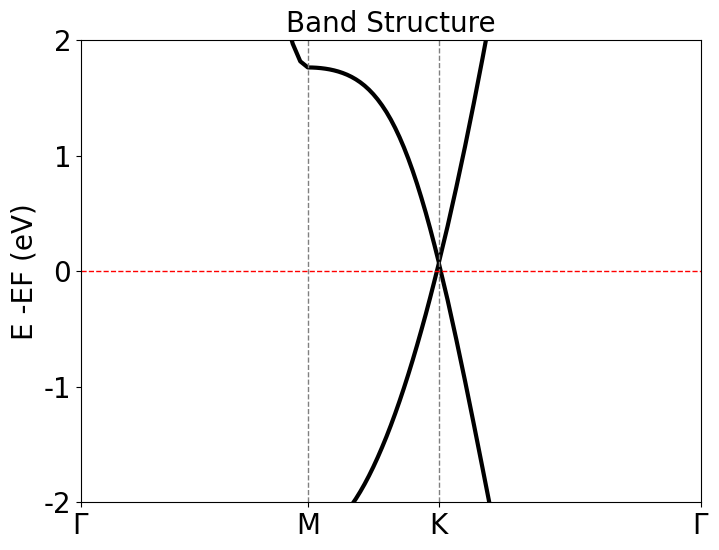

In [70]:
# graphene band

file = File()
file.Set_files_atributes({'files_folder': 'Examples/graphene/bands'})
file.Load()
file.Bands_files()
plot = Plot()
plot.bands(file.bands, file.k_points_letter, file.k_path,subplotsize=(8,6),E_min=-2,E_max=2,fermi_level_line=True)

<AxesSubplot:title={'center':'Band Structure'}, ylabel='E -EF (eV)'>

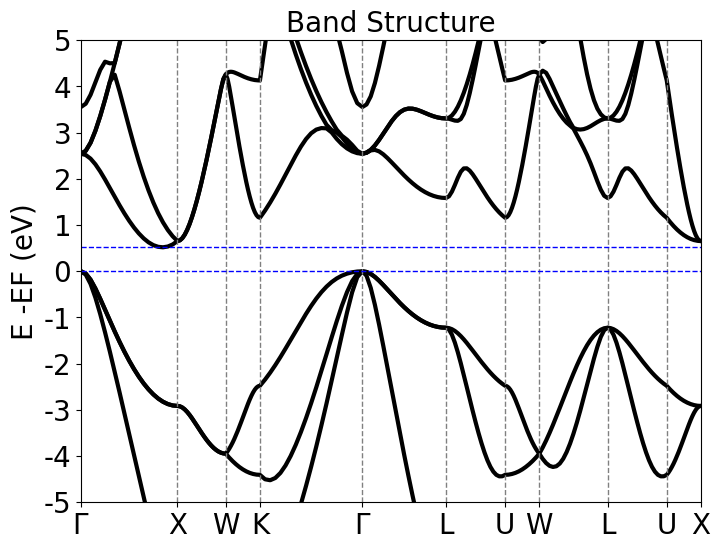

In [5]:
# Si-fcc band
si_fcc_names = {'files_folder': 'Examples/Si-fcc/bands/', 'scf_in_name': 'si.scf.in', 'scf_out_name': 'si.scf.out',
                'bands_in_name': 'si.bands.in', 'bands_out_name': 'si.bands.out', 'bandsx_name': 'si.bands-plot.out', 'bands_dat_name': 'si.band.gnu'}
file.Set_files_atributes(si_fcc_names)
file.Load()
file.Bands_files()
plot = Plot()
plot.bands(file.bands, file.k_points_letter, file.k_path, legend=False, occupied_and_unoccupied_states_line=True ,occupied_and_unoccupied_states=(file.E_valence,file.E_conduction), fermi_level_line=False,subplotsize=(8,6))


<AxesSubplot:title={'center':'Band Structure'}, ylabel='E -EF (eV)'>

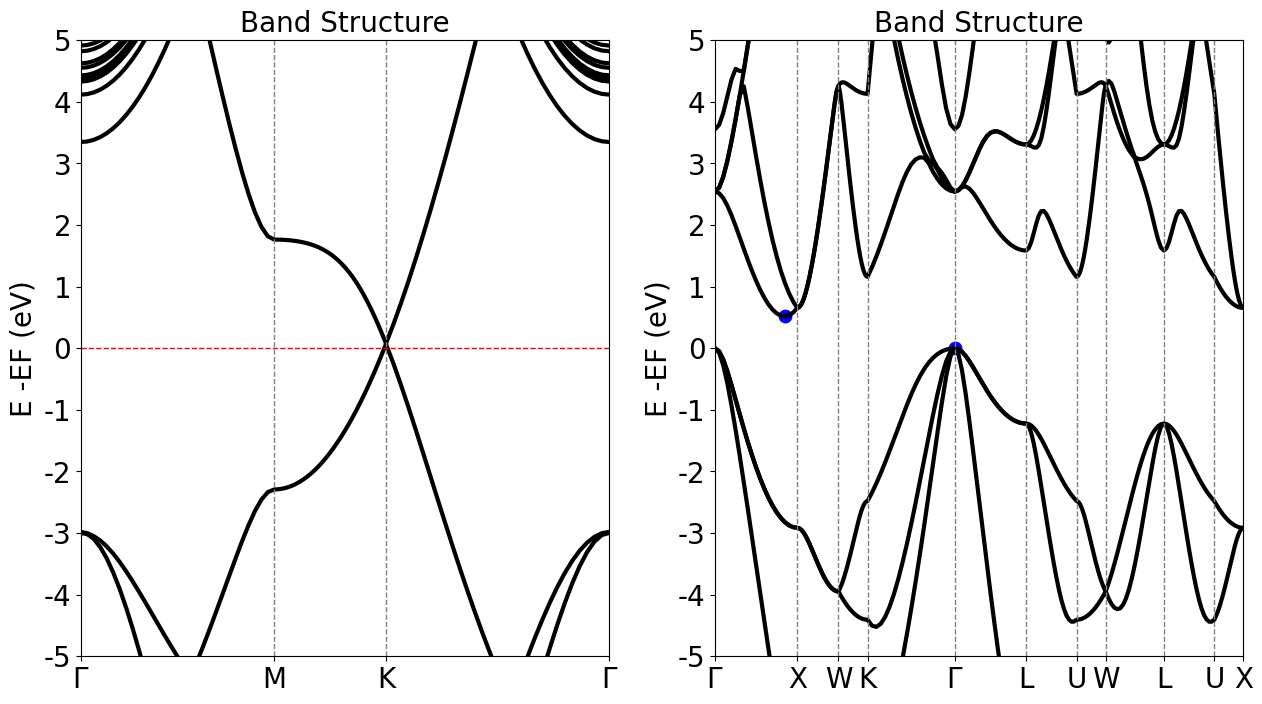

In [6]:
#plot bands graphene and si-fcc using subplot = true

file = File()
plot = Plot()
file.Set_files_atributes({'files_folder': 'Examples/graphene/bands'})
file.Load()
file.Bands_files()

fig, figura = plt.subplots(1, 2, figsize=(15, 8))
plot.bands(file.bands, file.k_points_letter, file.k_path, fermi_level_line= True, subplot=True, ax = figura[0])

si_fcc_names = {'files_folder': 'Examples/Si-fcc/bands/', 'scf_in_name': 'si.scf.in', 'scf_out_name': 'si.scf.out',
                'bands_in_name': 'si.bands.in', 'bands_out_name': 'si.bands.out', 'bandsx_name': 'si.bands-plot.out', 'bands_dat_name': 'si.band.gnu'}
file.Set_files_atributes(si_fcc_names)
file.Load()
file.Bands_files()
plot = Plot()
plot.bands(file.bands, file.k_points_letter, file.k_path, legend=False, subplot=True, ax = figura[1],occupied_and_unoccupied_states_dot=True,occupied_and_unoccupied_states_points=(file.E_valence_point,file.E_conduction_point))


<AxesSubplot:title={'center':'Density of States'}, xlabel='E - E_F (eV)', ylabel='DoS (states/eV)'>

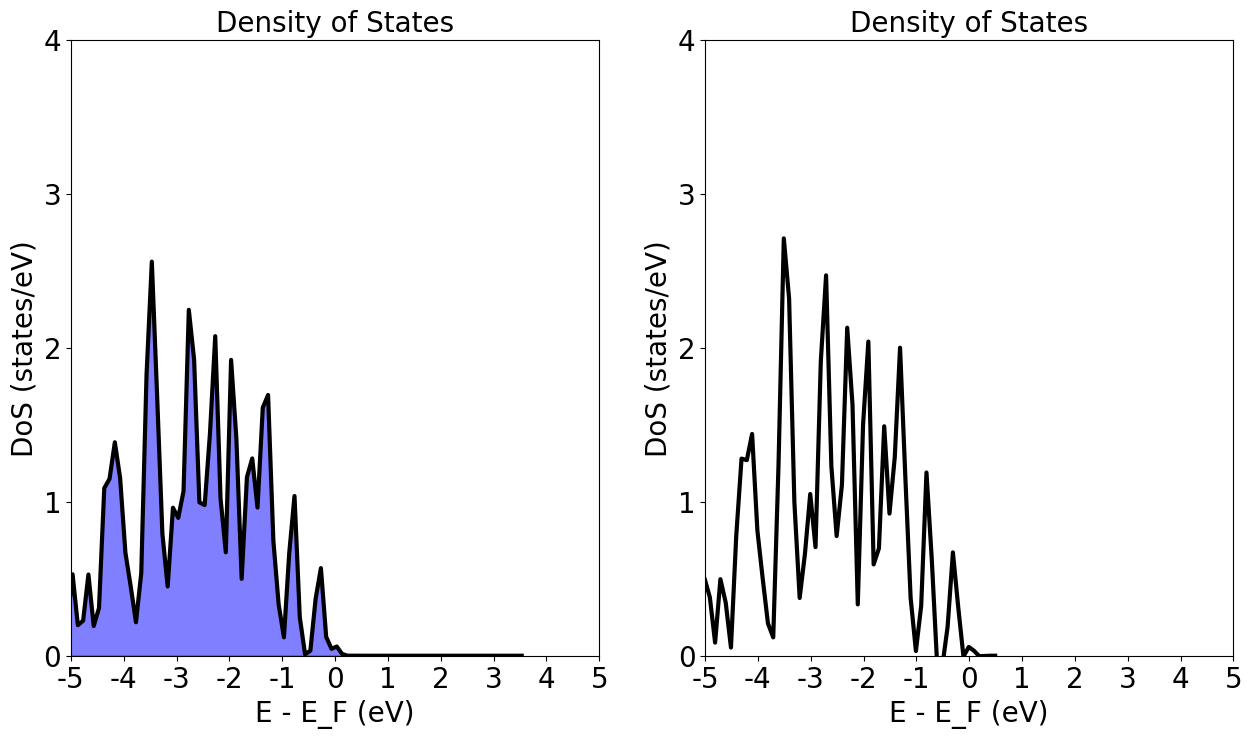

In [7]:
#plot dos e projwfc in the same figure using subplot = true

# dos via dos.x Si-fcc
file = File()
plot = Plot()
si_fcc_names['files_folder'] = 'Examples/Si-fcc/dos'
si_fcc_names['dos_dat_name'] = 'si.dos'
si_fcc_names['nscf_out_name'] = 'si.nscf.out'
file.Set_files_atributes(si_fcc_names)
file.Load()
file.Dos_files('dos.x')

fig, figura = plt.subplots(1, 2, figsize=(15, 8))

plot.dos(file.dos,dos_max= 4, delta_dos= 1,fill = True, subplot= True, ax = figura[0] )


# dos via projwfc.x Si-fcc

si_fcc_names['files_folder'] = 'Examples/Si-fcc/pdos'
si_fcc_names['pdos_dat_name'] = 'silicon.pdos_tot'
file.Set_files_atributes(si_fcc_names)
file.Load()
file.Dos_files('projwfc.x')

plot.dos(file.dos,dos_max= 4, delta_dos= 1, subplot= True, ax = figura[1] )

array([<AxesSubplot:title={'center':'Band Structure'}, ylabel='E -EF (eV)'>,
       <AxesSubplot:title={'center':'Density of States'}, xlabel='DoS (states/eV)'>],
      dtype=object)

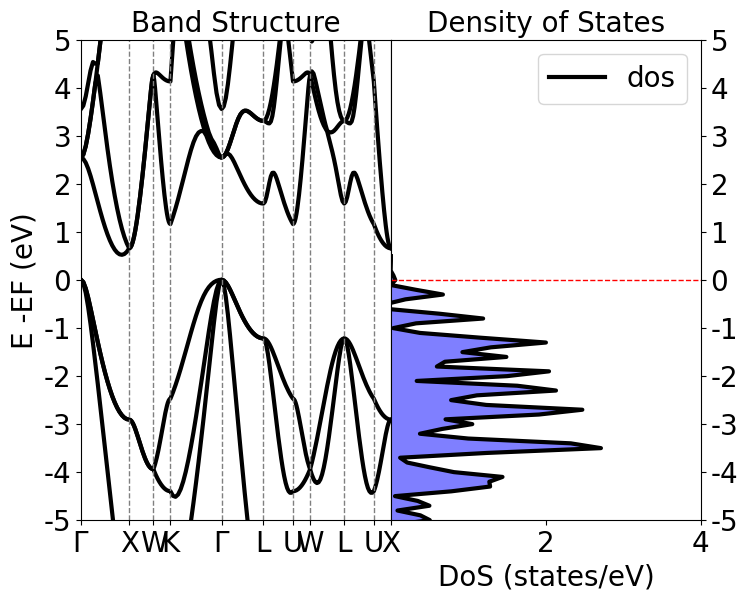

In [9]:
#plot band structure and dos Si-Fcc
file = File()
plot = Plot()

si_fcc_names = {'files_folder': 'Examples/Si-fcc/bands/', 'scf_in_name': 'si.scf.in', 'scf_out_name': 'si.scf.out',
                'bands_in_name': 'si.bands.in', 'bands_out_name': 'si.bands.out', 'bandsx_name': 'si.bands-plot.out', 'bands_dat_name': 'si.band.gnu'}
file.Set_files_atributes(si_fcc_names)
file.Load()
file.Bands_files()

si_fcc_names['files_folder'] = 'Examples/Si-fcc/pdos'
si_fcc_names['nscf_out_name'] = 'si.nscf.out'
si_fcc_names['pdos_dat_name'] = 'silicon.pdos_tot'
file.Set_files_atributes(si_fcc_names)
file.Load()
file.Dos_files('projwfc.x')

plot.bands_dos(file.bands, file.k_points_letter, file.k_path, file.dos, legend_bands =False,subplotsize = (8,6),  dos_max= 4)

<AxesSubplot:title={'center':'Density of States per Atom'}, xlabel='E - E_F (eV)', ylabel='DoS (states/eV)'>

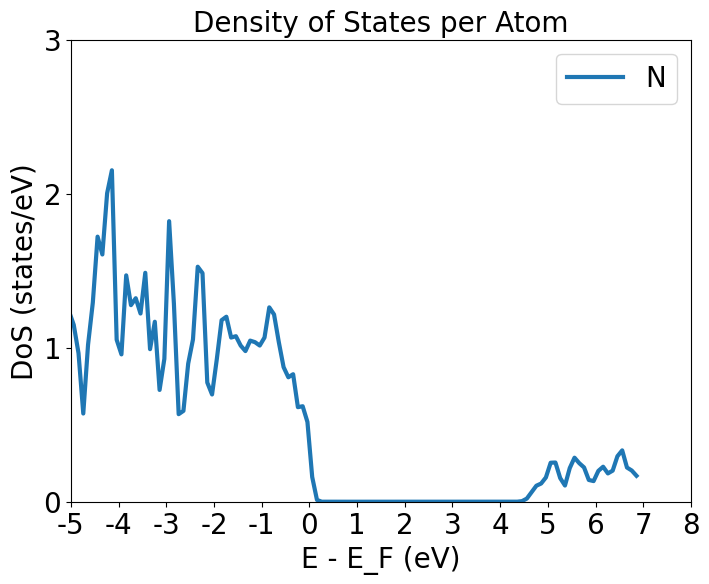

In [73]:
##plot pdos per atom BN
file = File()
plot = Plot()
names = {}
names['files_folder'] = 'Examples/BN/bands'
names['scf_in_name'] = 'bn.scf.in'
names['scf_out_name'] = 'bn.scf.out'

names['bands_in_name'] = 'bn.bands.in'
names['bands_out_name'] = 'bn.bands.out'
names['bandsx_name'] = 'bn.bands.x.out'
names['bands_dat_name'] = 'bn.band.dat.gnu'


names['files_folder'] = 'Examples/BN/pdos'
names['scf_in_name'] = 'bn.scf.in'
names['scf_out_name'] = 'bn.scf.out'

names['nscf_in_name'] = 'bn.nscf.in'
names['nscf_out_name'] = 'bn.nscf.out'
names['pdos_dat_name'] = 'bn.pdos.dat.pdos_tot'
names['pdos_prefix'] = 'bn'


file.Set_files_atributes(names)
file.Load()
file.Pdos_files()
plot.pdos_atoms(file.pdos_per_atoms,subplotsize=(8,6),all_atom=False,atom=['N'],dos_max= 3, E_max = 8)

<AxesSubplot:title={'center':'Density of States per Atom'}, xlabel='E - E_F (eV)', ylabel='DoS (states/eV)'>

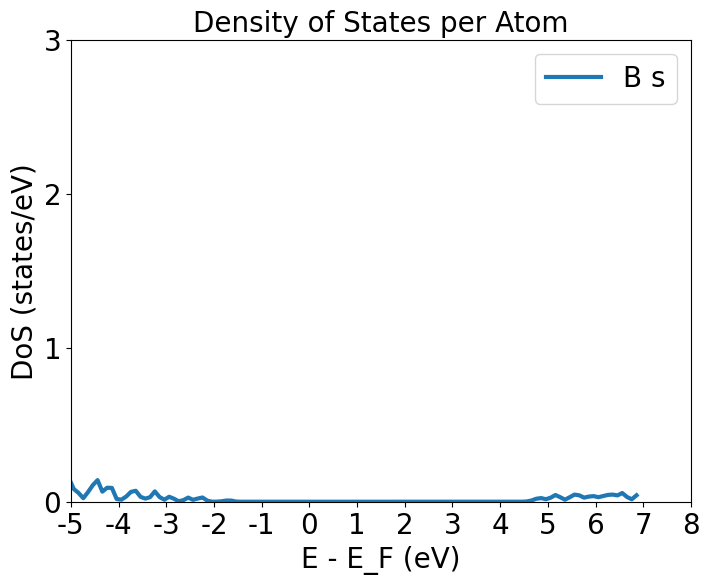

In [75]:
##plot pdos per atom BN
file = File()
plot = Plot()
names = {}
names['files_folder'] = 'Examples/BN/bands'
names['scf_in_name'] = 'bn.scf.in'
names['scf_out_name'] = 'bn.scf.out'

names['bands_in_name'] = 'bn.bands.in'
names['bands_out_name'] = 'bn.bands.out'
names['bandsx_name'] = 'bn.bands.x.out'
names['bands_dat_name'] = 'bn.band.dat.gnu'


names['files_folder'] = 'Examples/BN/pdos'
names['scf_in_name'] = 'bn.scf.in'
names['scf_out_name'] = 'bn.scf.out'

names['nscf_in_name'] = 'bn.nscf.in'
names['nscf_out_name'] = 'bn.nscf.out'
names['pdos_dat_name'] = 'bn.pdos.dat.pdos_tot'
names['pdos_prefix'] = 'bn'


file.Set_files_atributes(names)
file.Load()
file.Pdos_files()

plot.pdos_orb(file.pdos_per_orb,subplotsize=(8,6),dos_max= 3,E_max = 8,all_orb=False,orb={'B':'s'})

4.339


array([<AxesSubplot:title={'center':'Band Structure'}, ylabel='E -EF (eV)'>,
       <AxesSubplot:title={'center':'Density of States per Atom'}, xlabel='DoS (states/eV)'>],
      dtype=object)

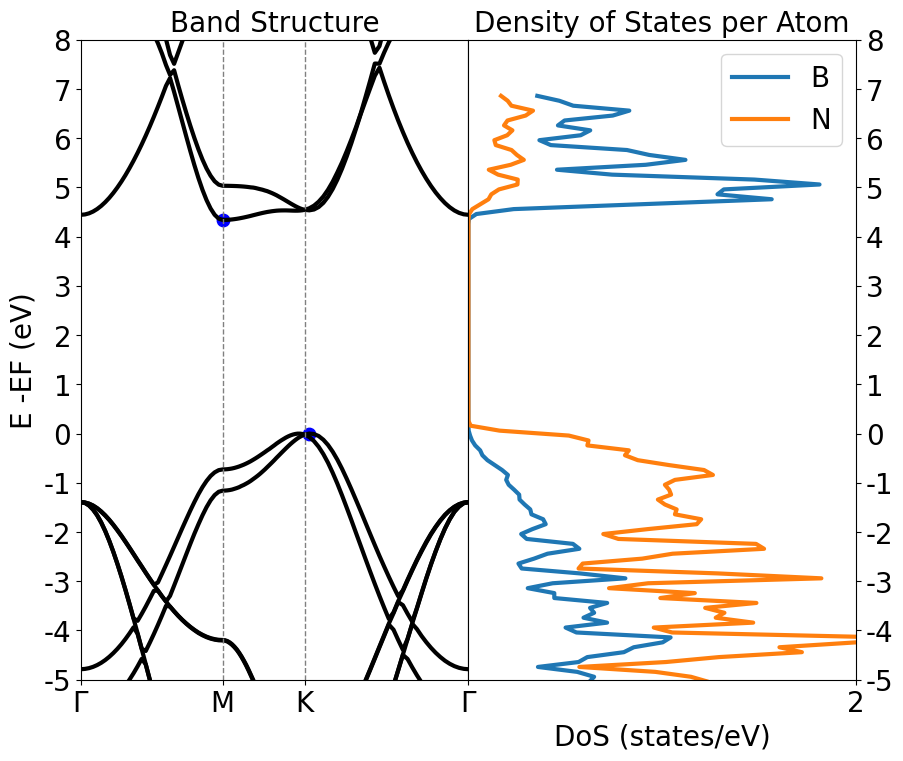

In [76]:
##plot pdos per atom BN
file = File()
plot = Plot()
names = {}
names['files_folder'] = 'Examples/BN/bands'
names['scf_in_name'] = 'bn.scf.in'
names['scf_out_name'] = 'bn.scf.out'

names['bands_in_name'] = 'bn.bands.in'
names['bands_out_name'] = 'bn.bands.out'
names['bandsx_name'] = 'bn.bands.x.out'
names['bands_dat_name'] = 'bn.band.dat.gnu'
file.Set_files_atributes(names)
file.Load()
file.Bands_files()
print(file.E_conduction)
names['files_folder'] = 'Examples/BN/pdos'
names['scf_in_name'] = 'bn.scf.in'
names['scf_out_name'] = 'bn.scf.out'

names['nscf_in_name'] = 'bn.nscf.in'
names['nscf_out_name'] = 'bn.nscf.out'
names['pdos_dat_name'] = 'bn.pdos.dat.pdos_tot'
names['pdos_prefix'] = 'bn'

file.Set_files_atributes(names)
file.Load()
file.Pdos_files()

plot.bands_pdos_atom(file.bands,file.k_points_letter,file.k_path,file.pdos_per_atoms,E_max= 8,all_atom=False, atom=['N','B'],dos_max= 2,occupied_and_unoccupied_states_dot=True,occupied_and_unoccupied_states_points=(file.E_valence_point,file.E_conduction_point))


array([<AxesSubplot:title={'center':'Band Structure'}, ylabel='E -EF (eV)'>,
       <AxesSubplot:title={'center':'Density of States per Atom'}, xlabel='DoS (states/eV)'>],
      dtype=object)

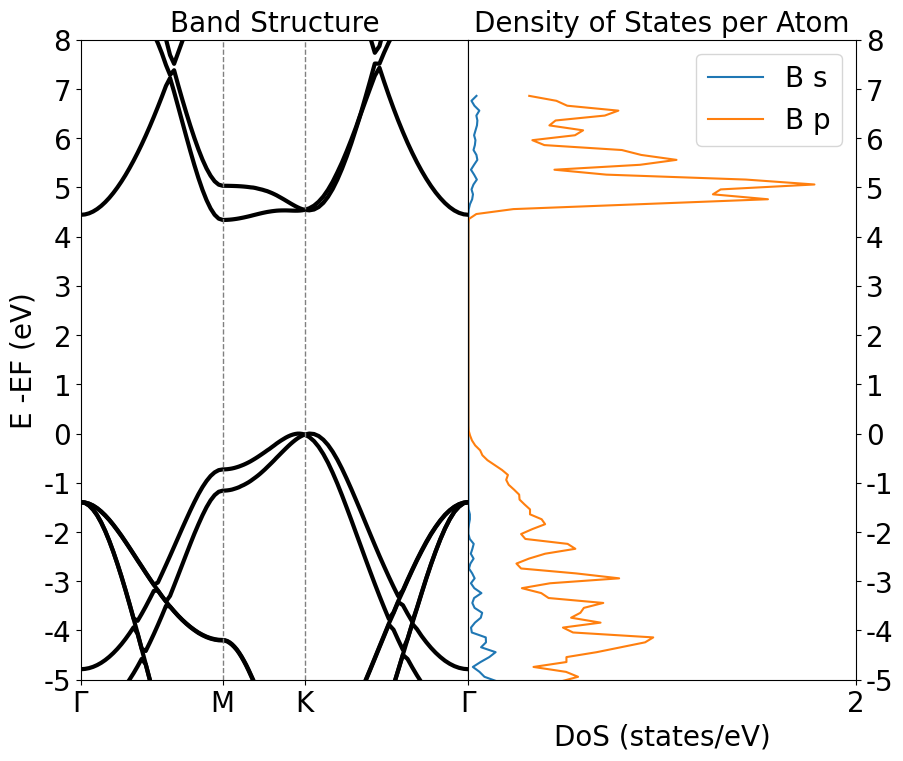

In [77]:
##plot pdos per atom BN
file = File()
plot = Plot()
names = {}
names['files_folder'] = 'Examples/BN/bands'
names['scf_in_name'] = 'bn.scf.in'
names['scf_out_name'] = 'bn.scf.out'

names['bands_in_name'] = 'bn.bands.in'
names['bands_out_name'] = 'bn.bands.out'
names['bandsx_name'] = 'bn.bands.x.out'
names['bands_dat_name'] = 'bn.band.dat.gnu'
file.Set_files_atributes(names)
file.Load()
file.Bands_files()

names['files_folder'] = 'Examples/BN/pdos'
names['scf_in_name'] = 'bn.scf.in'
names['scf_out_name'] = 'bn.scf.out'

names['nscf_in_name'] = 'bn.nscf.in'
names['nscf_out_name'] = 'bn.nscf.out'
names['pdos_dat_name'] = 'bn.pdos.dat.pdos_tot'
names['pdos_prefix'] = 'bn'

file.Set_files_atributes(names)
file.Load()
file.Pdos_files()

plot.bands_pdos_orb(file.bands,file.k_points_letter,file.k_path,file.pdos_per_orb,E_max= 8,dos_max= 2,all_orb= False,orb={'B':'all'})


In [4]:
file = File()
plot = Plot()

names = {}
names['files_folder'] = 'Examples/Bi2Te3/12per_Eu/bands/'
names['bands_dat_name'] = 'bands.dop12per.dat.gnu'
file.Set_files_atributes(names)
file.Load()
file.Bands_files()




<AxesSubplot:title={'center':'Band Structure'}, ylabel='E -EF (eV)'>

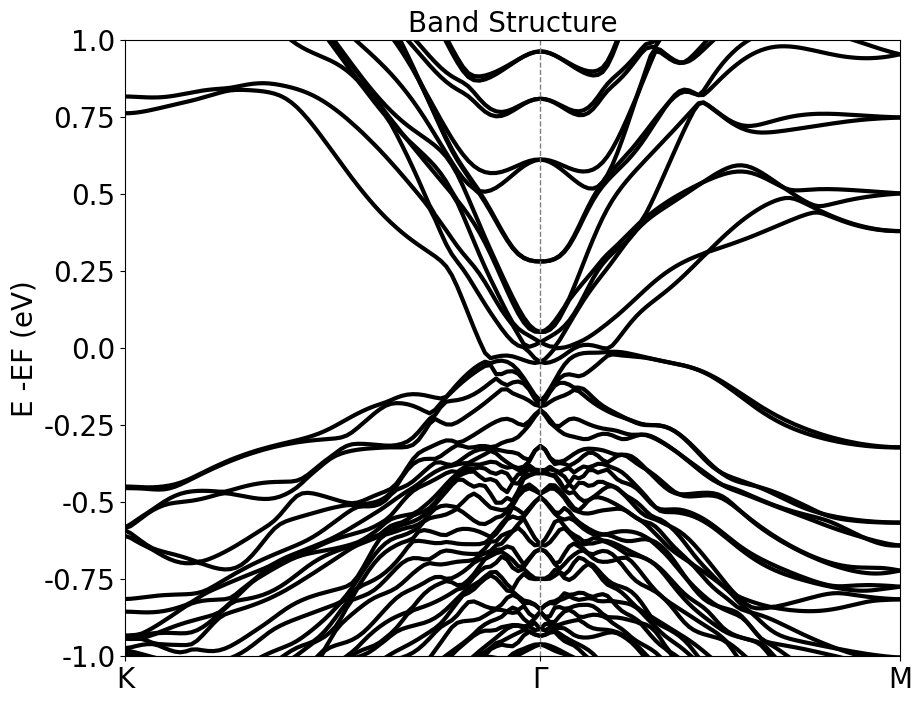

In [5]:
plot.bands(file.bands,file.k_points_letter,file.k_path,E_min=-1,E_max=1,dE = 0.25)